In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, ELU, BatchNormalization, PReLU, Add, Input,GlobalAveragePooling2D,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import gzip
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-balanced-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-balanced-test.csv'

chunk_size = 10000
train_data_iter = pd.read_csv(train_file_path, chunksize=chunk_size)
train_data = pd.concat([chunk for chunk in tqdm(train_data_iter, desc='Loading training data')])
test_data_iter = pd.read_csv(test_file_path, chunksize=chunk_size)
test_data = pd.concat([chunk for chunk in tqdm(test_data_iter, desc='Loading test data')])

print(train_data.shape, test_data.shape)

# 데이터의 차원과 크기를 정확히 파악
num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

# 데이터 준비
x_train = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train = train_data.iloc[:, 0].to_numpy()
y_test = test_data.iloc[:, 0].to_numpy()  

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("x_valid shape:", x_valid.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_valid shape:", y_valid.shape)


2024-05-18 23:48:09.068714: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 23:48:09.068747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 23:48:09.068776: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 23:48:09.074804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 23:48:09.811602: W tensorflow/compiler/

(112799, 785) (18799, 785)
x_train shape: (101519, 28, 28, 1)
x_test shape: (18799, 28, 28, 1)
x_valid shape: (11280, 28, 28, 1)
y_train shape: (101519,)
y_test shape: (18799,)
y_valid shape: (11280,)


In [3]:
def residual_block(x, filters, kernel_size=3, stride=1):
    y = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = PReLU()(y)
    y = Conv2D(filters, kernel_size, strides=1, padding='same')(y)
    y = BatchNormalization()(y)

    if stride != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, 1, strides=stride, padding='same')(x)
        x = BatchNormalization()(x)

    out = Add()([x, y])
    out = PReLU()(out)
    return out

input = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), padding='same')(input)
x = BatchNormalization()(x)
x = PReLU()(x)
x = Dropout(0.33)(x)
x = AveragePooling2D(pool_size=2, strides=2, padding='valid')(x)

x = residual_block(x, 64)
x = Dropout(0.33)(x)
x = AveragePooling2D(pool_size=2, strides=2, padding='valid')(x)

x = residual_block(x, 128)
x = Dropout(0.33)(x)
x = AveragePooling2D(pool_size=2, strides=2, padding='valid')(x)

x = residual_block(x, 256)
x = Dropout(0.33)(x)
x = AveragePooling2D(pool_size=2, strides=2, padding='valid')(x)

x = Flatten()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = PReLU()(x)
x = Dropout(0.6)(x)

output = Dense(47, activation='softmax')(x)

model = Model(inputs=input, outputs=output)


2024-05-18 23:48:14.430095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-18 23:48:14.455258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-18 23:48:14.455585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 p_re_lu (PReLU)             (None, 28, 28, 32)           25088     ['batch_normalization[0][0

In [3]:
optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=50, callbacks=[reduce_lr], batch_size=500)

# 모델 평가
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/50


2024-05-18 16:57:56.410605: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-18 16:57:57.924580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-05-18 16:57:59.694440: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x766260f46f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-18 16:57:59.694465: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-18 16:57:59.698116: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-18 16:57:59.776041: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster

204/204 [==============================] - 15s 29ms/step - loss: 1.1978 - accuracy: 0.6502 - val_loss: 0.4929 - val_accuracy: 0.8379 - lr: 0.0010
Epoch 2/50
204/204 [==============================] - 5s 25ms/step - loss: 0.4858 - accuracy: 0.8325 - val_loss: 0.3569 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 3/50
204/204 [==============================] - 5s 25ms/step - loss: 0.4109 - accuracy: 0.8550 - val_loss: 0.3404 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 4/50
204/204 [==============================] - 5s 26ms/step - loss: 0.3776 - accuracy: 0.8662 - val_loss: 0.3340 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 5/50
204/204 [==============================] - 5s 25ms/step - loss: 0.3498 - accuracy: 0.8736 - val_loss: 0.2984 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 6/50
204/204 [==============================] - 5s 25ms/step - loss: 0.3284 - accuracy: 0.8809 - val_loss: 0.2928 - val_accuracy: 0.8890 - lr: 0.0010
Epoch 7/50
204/204 [==============================] - 5s 23ms/step - loss:

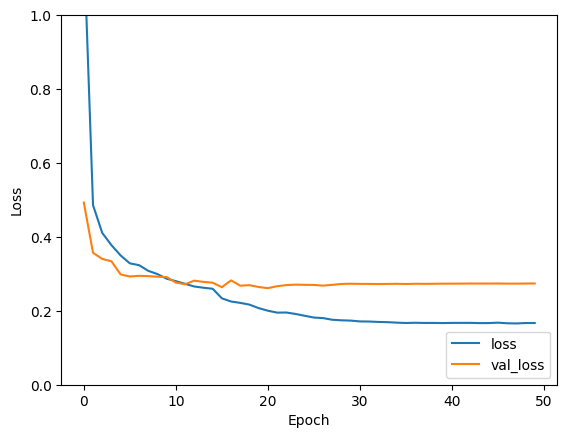

588/588 - 2s - loss: 0.2893 - accuracy: 0.9052 - 2s/epoch - 4ms/step
Test accuracy: 0.9052077531814575


In [4]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")